# Final Project Data Science Vizualization Notebook

#### Fake News Prediction on the FakeNewsCorpus

# Userguide
This notebook requires LoadingAndCleaning.py, Vizualizations.py and data from the FakeNewsCorpus to run. We also do some stats on some scraped wikinews, data from a Kaggle competition and the LIAR set at the end. The notebook can be run from start to end. We use booleans in section (1) to control relevant parameters.

# Vizualizations
This notebook goes through some data exploration, which explains some of the cleaning we have ended up doing, al though it does not report all the exploration we have done. It shows some basic statistics, and compares distribution of content length, word length, count of sentences between classes, as well as plotting a wordcloud of each class.

In [1]:
from LoadingAndCleaning import init_dataframe
import LoadingAndCleaning
import Vizualisations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")
from wordcloud import WordCloud
import pandas as pd

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
def adjust_df_labels_remove_fake(df): 
    df_real = df[df['label'] == 1]
    df_fake = df[df['label'] == 0]
    min_len = len(df_real)
    df_adjusted = df_real.append(df_fake.sample(n=min_len))
    
    return df_adjusted
    

In [3]:
def word_cloud(df, label, feature, genuine = True):

    # join all texts in resective labels, 0 being fake and 1 genuine
    if genuine:
        text_joined = " ".join(df[df[label]==0][feature])
    else:
        text_joined = " ".join(df[df[label]==1][feature])     

    stopwords = set(nltk.corpus.stopwords.words('english'))

    # Wordcloud for Genuine News
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(text_joined)                       
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# 1. Commands - Init dataframe

In [4]:
percent_load = 0.01
load_path = 'data/1mio-raw.csv'
use_multiprocessing = True
is_clean_authors_and_title = False # Wups, not treated ideally? (cleaned like content)

raw_df = init_dataframe(load_path, percent_load)
raw_df['content'] = raw_df['content'].astype('str')

raw_df['label'] = np.where(((raw_df['type'] == 'political') | (raw_df['type'] == 'reliable')), 1, 0)

raw_df = LoadingAndCleaning.trim_df(raw_df)

raw_df['raw_content_length'] = raw_df['content'].apply(lambda x: len(x))

Initializing dataframe...
Initialized data (9958 entries) in: 4.2 seconds


In [5]:
raw_df.head(2)

,domain,type,url,content,title,authors,scraped_at,label,raw_content_length
0,baptistnews.com,political,https://baptistnews.com/article/marching-towar...,"Flowing like a pink river, scores of women in ...",Marching toward the future for gender equality...,Molly T. Marshall,2018-01-25 16:17:44.789555,1,4758
1,clickhole.com,satire,http://www.clickhole.com/article/cleaning-hous...,I am 18 or over and willing to view sexually e...,Cleaning House: The National Audubon Society H...,,2018-01-25 16:17:44.789555,0,70


# 2. Look at label distribution, we notice we have mostly fake type (70/30) split. We choose to balance this manually by sampling fake types away until we have even distribution

In [6]:
#raw_df['label'].value_counts(normalize=True)
raw_df['label'].value_counts()

0    4240
1    2689
Name: label, dtype: int64

In [7]:
raw_df = adjust_df_labels_remove_fake(raw_df)

In [8]:
raw_df['label'].value_counts()

1    2689
0    2689
Name: label, dtype: int64

# 3. We now look at content length distribution, and ntoice we have no very short articles, but a few at 24,000 to 100,000 (10-40 pages)

In [9]:
raw_df['raw_content_length'].mean()

3323.1807363332096

In [10]:
print(len(raw_df[raw_df['raw_content_length'] < 20]))

0


In [11]:
print(len(raw_df[raw_df['raw_content_length'] > 24000]))

0


In [12]:
### 3.1 We also notice genuine articles have longer articles than fake it seems

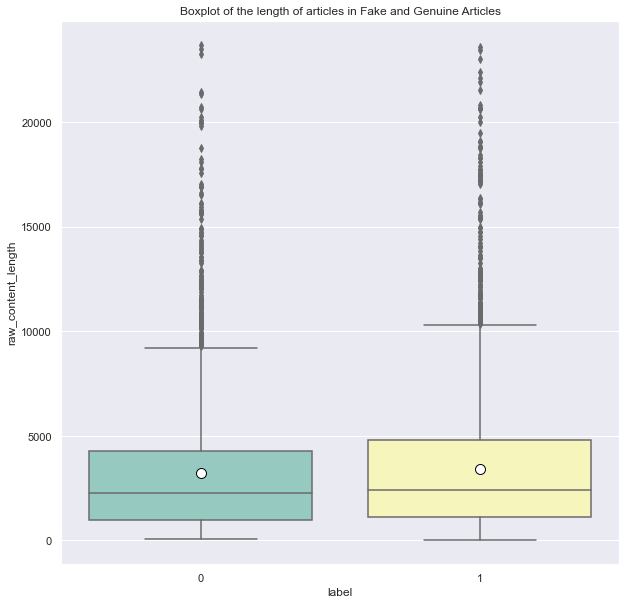

In [13]:
sns.boxplot(y='raw_content_length', x='label', data=raw_df, palette="Set3", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the length of articles in Fake and Genuine Articles")
plt.show()

#### In fact, we see that only around 0.5% of the data is more than 24000 long, so we decide to remove this

In [14]:
print("Percent of articles with more than 24000 characters in content")
(len(raw_df[raw_df['raw_content_length'] > 24000]) / len(raw_df) )* 100

Percent of articles with more than 24000 characters in content


0.0

# 2.2 We remove them and plot length distribution again again

In [15]:
raw_df = raw_df[raw_df['raw_content_length'] < 24000]

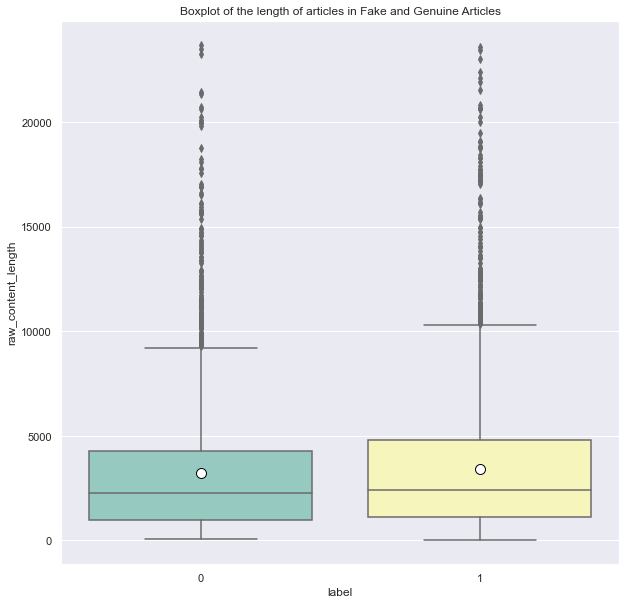

In [16]:
sns.boxplot(y='raw_content_length', x='label', data=raw_df, palette="Set3",showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the length of articles in Fake and Genuine Articles")
plt.show()

# 2.3 We now do the rest of our cleaning and processing, and plot content length again, notice we get a big decrease


In [17]:
use_multiprocessing = True
df_copy = raw_df.copy(deep=True)
df = LoadingAndCleaning.clean_df(df_copy, use_multiprocessing, is_clean_authors_and_title)
#df = LoadingAndCleaning.drop_empty_string_rows(df)
df = LoadingAndCleaning.process_df(df)

Cleaning...
Cleaned (5378 entries) in: 3.0 seconds
Processing...
Processed(5378 entries) in: 7.7 seconds


In [18]:
df.head(3)

,domain,type,url,content,title,authors,scraped_at,label,raw_content_length,content_joined,content_length
0,baptistnews.com,political,https://baptistnews.com/article/marching-towar...,"[flowing, like, pink, river, scores, women, tr...","[Marching, toward, future, gender, equality, –...","[Molly, T., Marshall]",2018-01-25 16:17:44.789555,1,4758,flowing like pink river scores women trademark...,429
2,baptistnews.com,political,https://baptistnews.com/tag/west-side-communit...,"[enderly, park, blistering, unseasonable, sept...","[West, Side, Community, Land, Trust, Archives,...","[Blake, Tommey]",2018-01-25 16:17:44.789555,1,240,enderly park blistering unseasonable september...,23
13,christianpost.com,reliable,https://www.christianpost.com/news/members-tur...,"[expand, collapse, photo, facebook, pastor, ca...","[Members, Turned, Away, From, Church, Congrega...",[],2018-01-25 16:17:44.789555,1,3209,expand collapse photo facebook pastor cameron ...,293


In [19]:
df['content_length'].mean()

314.62755671253257

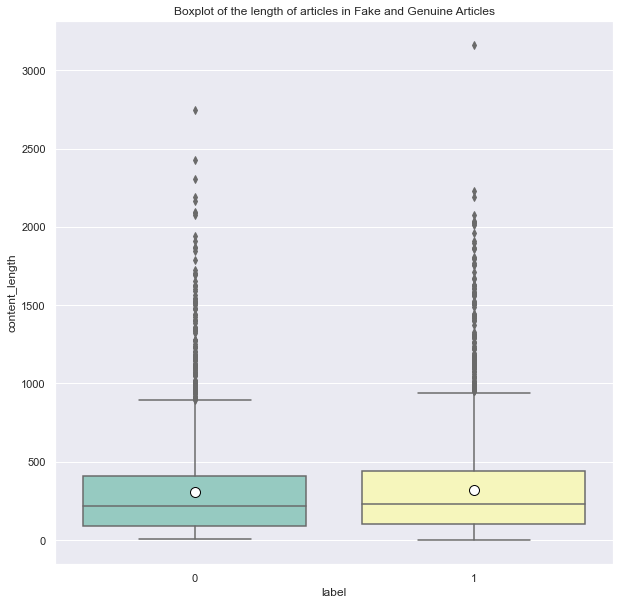

In [20]:
sns.boxplot(y='content_length', x='label', data=df, palette="Set3",showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the length of articles in Fake and Genuine Articles")
plt.show()

# 4. Now we try making word clouds

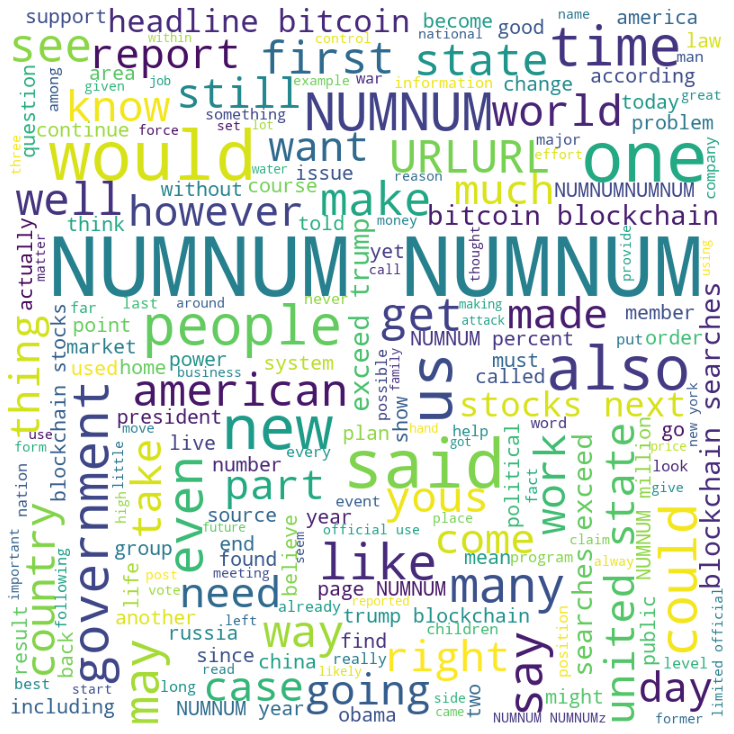

In [21]:
word_cloud(df, label='label', feature='content_joined', genuine=True)

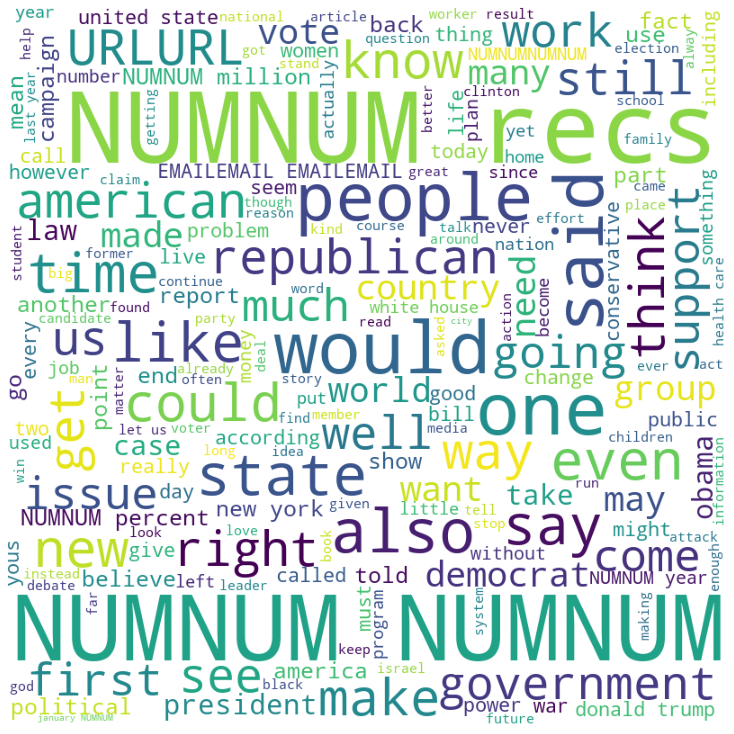

In [22]:
word_cloud(df, label='label', feature='content_joined', genuine=False)

# 5. We now try and show number of sentences

In [23]:
%%time
# preprocess for viz
df_copy = Vizualisations.format_df_copy(raw_df)

Wall time: 33.6 s


In [24]:
df_copy.head(3)

,domain,type,url,content,title,authors,scraped_at,label,raw_content_length,sent_tokens,len_sentence,sent_word_tokens,avg_words_per_sent,avg_word_length
0,baptistnews.com,political,https://baptistnews.com/article/marching-towar...,"Flowing like a pink river, scores of women in ...",Marching toward the future for gender equality...,Molly T. Marshall,2018-01-25 16:17:44.789555,1,4758,"[Flowing like a pink river, scores of women in...",41,"[[Flowing, like, a, pink, river, scores, of, w...",20.170732,4.649335
2,baptistnews.com,political,https://baptistnews.com/tag/west-side-communit...,Enderly Park is blistering under an unseasonab...,West Side Community Land Trust Archives – Bapt...,Blake Tommey,2018-01-25 16:17:44.789555,1,240,[Enderly Park is blistering under an unseasona...,2,"[[Enderly, Park, is, blistering, under, an, un...",22.000000,4.500000
13,christianpost.com,reliable,https://www.christianpost.com/news/members-tur...,Expand | Collapse (Photo: Facebook) Pastor Cam...,Members Turned Away From Church as Congregants...,,2018-01-25 16:17:44.789555,1,3209,[Expand | Collapse (Photo: Facebook) Pastor Ca...,25,"[[Expand, Collapse, Photo, Facebook, Pastor, C...",21.000000,4.899048


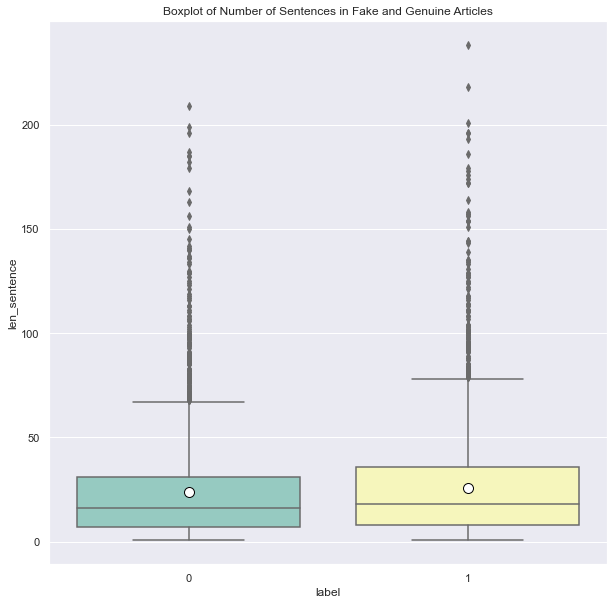

In [25]:
# Notice it IS number of sentences, not sentence length. len_sentence refers to len of "sentence tokens",
# and the len of the list of tokens, is the count of sentences
sns.boxplot(y='len_sentence', x='label', data=df_copy, palette="Set3",showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of Number of Sentences in Fake and Genuine Articles")
#plt.ylim(0, 100) # Uncomment to zoom in
plt.ylim(None, None) 
plt.show()

# Avg. number of words

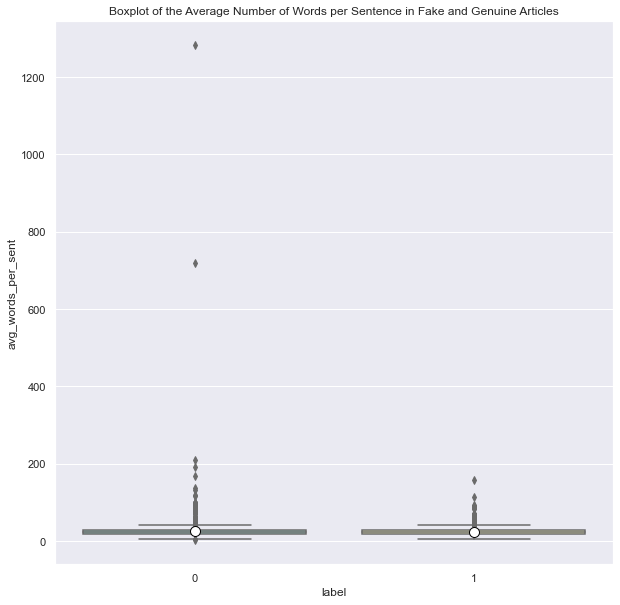

In [26]:
sns.boxplot(y='avg_words_per_sent', x='label', data=df_copy, palette="Set3",showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")
plt.ylim(None, None) 
plt.show()

# Avg. word lengths

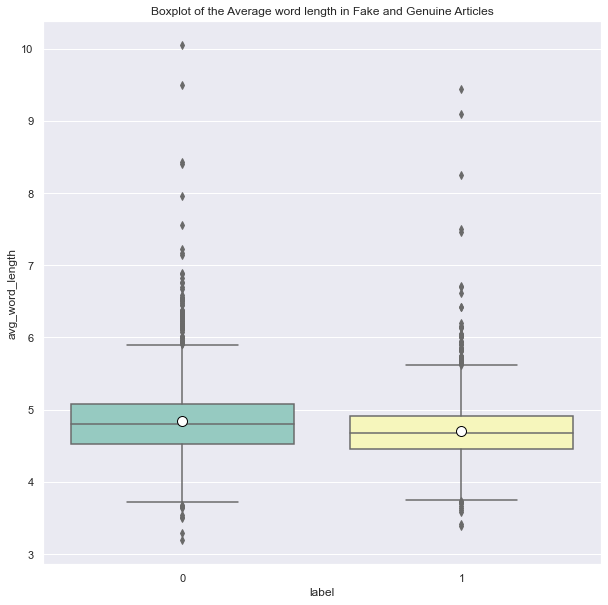

In [27]:
sns.boxplot(y='avg_word_length', x='label', data=df_copy, palette="Set3", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the Average word length in Fake and Genuine Articles")
plt.ylim(None, None) 
plt.show()

# 6. Short look at wikinews too

In [28]:
def load_and_clean_wikinews():
    wiki_df = pd.read_csv('data/wiki_data.csv', index_col=[0])
    wiki_df['url'] = 0
    wiki_df['scraped_at'] = 0
    wiki_df['type'] = 1
    wiki_df['domain'] = 0
    wiki_df['authors'] = ""
    wiki_df['content'] = wiki_df['content'].astype('str')
    wiki_df = LoadingAndCleaning.trim_df_only_content(wiki_df)
    wiki_df['raw_content_joined'] = wiki_df['content'].apply(lambda x: len(x))
    wiki_df = LoadingAndCleaning.clean_df_only_content(wiki_df)
    wiki_df['label'] = 1
    wiki_df = LoadingAndCleaning.process_df_only_content(wiki_df)
    
    return wiki_df

In [29]:
wiki_news = load_and_clean_wikinews()

Cleaning...
Cleaned (3323 entries) in: 1.9 seconds
Processing...
Processed(3323 entries) in: 3.2 seconds


In [30]:
wiki_news.head()

,type,content,label,raw_content_joined,content_joined,content_length
0,1,"[free, trade, zone, antalya, turkey, NUMNUM, w...",1,5913,free trade zone antalya turkey NUMNUM women wo...,536
1,1,"[three, police, officers, NUMNUM, batalhãof, d...",1,3034,three police officers NUMNUM batalhãof da pm m...,307
2,1,"[novak, story, sparked, contoversy, written, j...",1,2636,novak story sparked contoversy written july NU...,315
3,1,"[israeli, prime, minister, ehud, olmert, pales...",1,2191,israeli prime minister ehud olmert palestinian...,213
4,1,"[palestinian, authority, chairman, mahmoud, ab...",1,887,palestinian authority chairman mahmoud abbas f...,89


In [31]:
wiki_news['raw_content_joined'].mean()

2421.343364429732

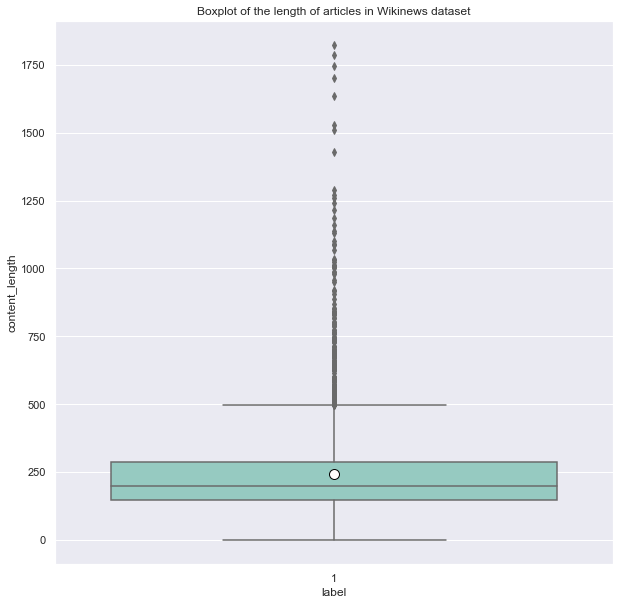

In [32]:
sns.boxplot(y='content_length', x='label', data=wiki_news, palette="Set3", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title("Boxplot of the length of articles in Wikinews dataset")
plt.show()

In [33]:
wiki_news['content_length'].mean()

240.19951850737286

# 7. Looking at LIAR too

In [34]:
def prepare_liar():
    liar_path = "data/liar_dataset/test.tsv"
    liar_df = pd.read_csv(liar_path, sep='\t', names=["ID", "label", "statement", "subject", "speaker", "job title", "state ", "party ","total credit", "barely true counts","false counts", "half true counts", "mostly true counts", "pants on fire counts","context "])
    liar_df['custom_label'] = np.where(((liar_df['label'] == 'true') | (liar_df['label'] == 'mostly-true')), 1, 0)
    liar_df = liar_df.dropna(subset=['label', 'statement'])
    liar_df['statement'] = liar_df['statement'].str.strip()
    liar_df = liar_df.drop_duplicates(subset="statement") 
    liar_df['raw_statement_len'] = liar_df['statement'].apply(lambda x: len(x))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.tokenize, np.array_split(liar_df["statement"], 32)))
    liar_df["statement"] = pd.concat(map(LoadingAndCleaning.remove_stopwords, np.array_split(liar_df["statement"], 32)))
    liar_df["statement_joined"] = pd.concat(map(LoadingAndCleaning.recombine_content, np.array_split(liar_df["statement"], 32)))
    liar_df["statement_len"] = pd.concat(map(LoadingAndCleaning.add_content_length, np.array_split(liar_df["statement"], 32)))
    return liar_df

In [35]:
liar_df = prepare_liar()

In [36]:
liar_df['statement_len'].mean()

11.26440410418311

In [37]:
len(liar_df)

1267

## average un processed content length

In [38]:
liar_df['raw_statement_len'].mean()

109.5761641673244

In [39]:
liar_df.head(2)

,ID,label,statement,subject,speaker,job title,state,party,total credit,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context,custom_label,raw_statement_len,statement_joined,statement_len
0,11972.json,true,"[building, wall, yousmexico, border, take, lit...",immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,NaN,1,68,building wall yousmexico border take literally...,7
1,11685.json,false,"[wisconsin, pace, double, number, layoffs, year]",jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,NaN,0,63,wisconsin pace double number layoffs year,6


# 8. Lets look at Kaggle as well

In [40]:
# Adjustable cleaner
def custom_clean(df, feature):
    feature_joined = feature + "_joined"
    df[feature] = pd.concat(map(LoadingAndCleaning.clean_content, np.array_split(df[feature], 32)))
    df[feature] = pd.concat(map(LoadingAndCleaning.tokenize, np.array_split(df[feature], 32)))
    df[feature] = pd.concat(map(LoadingAndCleaning.remove_stopwords, np.array_split(df[feature], 32)))
    df[feature_joined] = pd.concat(map(LoadingAndCleaning.recombine_content, np.array_split(df[feature], 32)))
    return df
def prepare_kaggle():
    kaggle_path = "data/kaggle_test_data/test_set.json"
    kaggle_df = pd.read_json(kaggle_path)
    kaggle_df['raw_article_len'] = kaggle_df['article'].apply(lambda x: len(x))
    kaggle_df = custom_clean(kaggle_df, "article")
    kaggle_df["article_len"] = pd.concat(map(LoadingAndCleaning.add_content_length, np.array_split(kaggle_df["article"], 32)))
    return kaggle_df

In [41]:
kaggle_df = prepare_kaggle()

In [42]:
kaggle_df['raw_article_len'].mean()

4706.989739542226

In [43]:
print(len(kaggle_df[kaggle_df['raw_article_len'] > 24000]))

62


In [44]:
kaggle_df.head(2)

,id,article,raw_article_len,article_joined,article_len
0,8476,"[daniel, greenfield, shillman, journalism, fel...",7516,daniel greenfield shillman journalism fellow f...,671
1,10294,"[google, pinterest, digg, linkedin, reddit, st...",2646,google pinterest digg linkedin reddit stumbleu...,239
